In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class_names = ['armyworm','beetle','cicadellidae','cricket','grasshopper','limacodidae','lycorma_delicatula','mosquito','weevil']

In [3]:
cd drive/MyDrive

/content/drive/MyDrive


In [4]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Activation,Dropout,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
import numpy as np
import os
import glob
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [5]:
image_size = 224
data_path = 'data'
IMG_SIZE = (224,224, 3)

In [6]:
def build_model(n_class=3):
    incept_model = InceptionV3(input_shape=IMG_SIZE, include_top = False, weights = "imagenet")

    last_layer = incept_model.get_layer('mixed10')
    last_output = last_layer.output

    for layer in incept_model.layers:
        if isinstance(layer ,tf.keras.layers.BatchNormalization):
          layer.trainable=False

    x = GlobalAveragePooling2D()(last_output)
    x = Dense(1024, activation="relu")(x)
    x = Dense(n_class, activation="softmax")(x)

    # Compile
    my_model = Model(incept_model.input, x)
    my_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = "categorical_crossentropy", metrics = ['accuracy'])

    return my_model


In [7]:
def load_data(data_path, class_names, image_size):
    data = []
    label = []
    for i_class in class_names:
        read_path = os.path.join(data_path, i_class,"*")
        print(read_path)
        for file in glob.glob(read_path):
            # Read
            print(file)
            image = cv2.imread(file)
            # Resize
            image = cv2.resize(image, dsize=(image_size, image_size))
            # Add to data
            data.append(image)
            label.append(i_class)

    # Encode labels from text to onehot
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(label)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    # Change to numpy array
    label = onehot_encoded
    data = np.array(data)
    
    return data, label, label_encoder



In [8]:
from sklearn.model_selection import train_test_split
# Make model
my_model = build_model(len(class_names))

# Load data train from folder
X, y, le = load_data(os.path.join(data_path), class_names, image_size)

# Load data test from folder
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=100)
print(X_train.shape)
print(X_test.shape)

import pickle
file = open('le.pkl', 'wb')
pickle.dump(le, file)
file.close()


Streaming output truncated to the last 5000 lines.
data/armyworm/16929.jpg
data/armyworm/16917.jpg
data/armyworm/16874.jpg
data/armyworm/16925.jpg
data/armyworm/16960.jpg
data/armyworm/16898.jpg
data/armyworm/16857.jpg
data/armyworm/16962.jpg
data/armyworm/16889.jpg
data/armyworm/16932.jpg
data/armyworm/16930.jpg
data/armyworm/16879.jpg
data/armyworm/16839.jpg
data/armyworm/16824.jpg
data/armyworm/16865.jpg
data/armyworm/16918.jpg
data/armyworm/16943.jpg
data/armyworm/16878.jpg
data/armyworm/16903.jpg
data/armyworm/16965.jpg
data/armyworm/16952.jpg
data/armyworm/16893.jpg
data/armyworm/16924.jpg
data/armyworm/16897.jpg
data/armyworm/16850.jpg
data/armyworm/16967.jpg
data/armyworm/16859.jpg
data/armyworm/16963.jpg
data/armyworm/16950.jpg
data/armyworm/16831.jpg
data/armyworm/16843.jpg
data/armyworm/16933.jpg
data/armyworm/16885.jpg
data/armyworm/16832.jpg
data/armyworm/16934.jpg
data/armyworm/16938.jpg
data/armyworm/16931.jpg
data/armyworm/16976.jpg
data/armyworm/16949.jpg
data/armyworm

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [10]:
aug = ImageDataGenerator(
      # rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [11]:
#filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath="ICT-w-max.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [12]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
import time
start = time.time()
hist = my_model.fit_generator(aug.flow(X_train, y_train, batch_size = 64), callbacks=callbacks_list, epochs=100, validation_data=aug.flow(X_test, y_test, batch_size = 64), verbose=1)
end = time.time()
print("Training time : ", end - start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 3.2290 - accuracy: 0.1505
Epoch 1: val_accuracy improved from -inf to 0.19630, saving model to ICT-w-max.hdf5
68/68 [==============================] - 87s 1s/step - loss: 3.2290 - accuracy: 0.1505 - val_loss: 2.0953 - val_accuracy: 0.1963
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 2.0841 - accuracy: 0.2016
Epoch 2: val_accuracy improved from 0.19630 to 0.22222, saving model to ICT-w-max.hdf5
68/68 [==============================] - 67s 980ms/step - loss: 2.0841 - accuracy: 0.2016 - val_loss: 1.9986 - val_accuracy: 0.2222
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 1.9702 - accuracy: 0.2560
Epoch 3: val_accuracy improved from 0.22222 to 0.29722, saving model to ICT-w-max.hdf5
68/68 [==============================] - 67s 989ms/step - loss: 1.9702 - accuracy: 0.2560 - val_loss: 1.8944 - val_accuracy: 0.2972
Epoch 4/100
68/68 [==============================] - ETA: 0s - l

In [14]:
my_model.save("ICT-w-last.hdf5")

In [15]:
import matplotlib.pyplot as plt
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


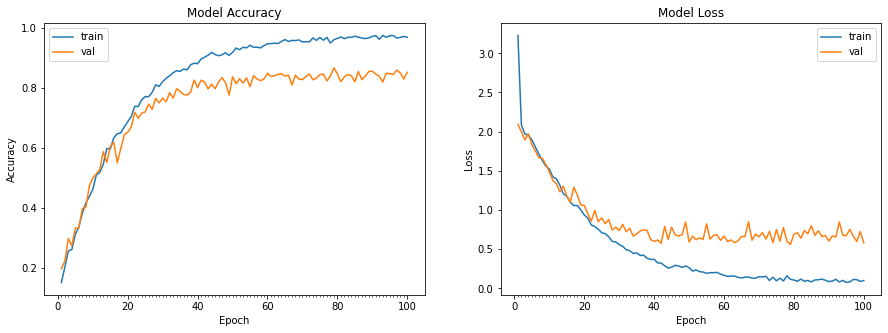

In [16]:
plot_model_history(hist)